This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Clutter detection by using space-born cloud images

In [1]:
import numpy as np

import xarray as xr
import xradar as xd
import wradlib as wrl
import matplotlib.pyplot as plt
from osgeo import osr

try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()

### Read the radar data into DataTree

In [2]:
# read the radar volume scan
filename = "hdf5/20130429043000.rad.bewid.pvol.dbzh.scan1.hdf"
filename = wrl.util.get_wradlib_data_file(filename)
pvol = xd.io.open_odim_datatree(filename)
display(pvol)

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2013-04-29T04:30:00Z'
│       time_coverage_end    <U20 '2013-04-29T04:31:39Z'
│       longitude            float64 5.506
│       altitude             float64 592.0
│       latitude             float64 49.91
│   Attributes:
│       Conventions:      ODIM_H5/V2_1
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
├── DataTree('sweep_0')
│       Dimensions:            (azimuth: 360, range: 960)
│       Coordinates:
│         * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2013-04-29T04:30:00.027777792...
│         * range              (range) float32 125.0 375.0 625.0 ... 2.396e+05 2.399e+05
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_1')
│       Dimensions:            (azimuth: 360, range: 960)
│       Coordinates:
│         * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2013-04-29T04:30:20.027777792...
│         * range              (range) float32 125.0 375.0 625.0 ... 2.396e+05 2.399e+05
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_2')
│       Dimensions:            (azimuth: 360, range: 960)
│       Coordinates:
│         * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2013-04-29T04:30:40.027777792...
│         * range              (range) float32 125.0 375.0 625.0 ... 2.396e+05 2.399e+05
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_3')
│       Dimensions:            (azimuth: 360, range: 960)
│       Coordinates:
│         * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2013-04-29T04:31:00.027777792...
│         * range              (range) float32 125.0 375.0 625.0 ... 2.396e+05 2.399e+05
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│         

# Georeference sweeps

In [3]:
pvol = pvol.filter(lambda x: "sweep" in x.name)
vol = []
for sweep in pvol.values():
    vol.append(sweep.ds.pipe(wrl.georef.georeference))
vol = xr.concat(vol, dim="tilt")
vol = vol.assign_coords(sweep_mode=vol.sweep_mode)
display(vol)

<xarray.Dataset>
Dimensions:            (tilt: 5, azimuth: 360, range: 960)
Coordinates: (12/15)
  * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation          (tilt, azimuth) float32 0.3 0.3 0.3 0.3 ... 6.0 6.0 6.0
    time               (tilt, azimuth) datetime64[ns] 2013-04-29T04:30:00.027...
  * range              (range) float32 125.0 375.0 625.0 ... 2.396e+05 2.399e+05
    sweep_mode         (tilt) <U20 'azimuth_surveillance' ... 'azimuth_survei...
    longitude          float64 5.506
    ...                 ...
    y                  (tilt, azimuth, range) float32 125.0 375.0 ... 2.378e+05
    z                  (tilt, azimuth, range) float32 592.0 594.0 ... 2.901e+04
    gr                 (tilt, azimuth, range) float32 125.0 375.0 ... 2.378e+05
    rays               (azimuth, range) float32 0.5 0.5 0.5 ... 359.5 359.5
    bins               (azimuth, range) float32 125.0 375.0 ... 2.399e+05
    spatial_ref        int64 0
Dimensions without coordinates: tilt
Data variables:
    DBZH               (tilt, azimuth, range) float32 -32.0 -32.0 ... -32.0
    sweep_number       (tilt) int64 0 1 2 3 4
    prt_mode           (tilt) <U7 'not_set' 'not_set' ... 'not_set' 'not_set'
    follow_mode        (tilt) <U7 'not_set' 'not_set' ... 'not_set' 'not_set'
    sweep_fixed_angle  (tilt) float64 0.3 0.9 1.8 3.3 6.0

### Construct collocated satellite data

In [4]:
proj_radar = osr.SpatialReference()
proj_radar.ImportFromWkt(vol.spatial_ref.attrs["crs_wkt"])

0

In [5]:
filename = "hdf5/SAFNWC_MSG3_CT___201304290415_BEL_________.h5"
filename = wrl.util.get_wradlib_data_file(filename)

In [6]:
sat_gdal = wrl.io.read_safnwc(filename)
val_sat = wrl.georef.read_gdal_values(sat_gdal)
coord_sat = wrl.georef.read_gdal_coordinates(sat_gdal)
proj_sat = wrl.georef.read_gdal_projection(sat_gdal)
coord_sat = wrl.georef.reproject(coord_sat, src_crs=proj_sat, trg_crs=proj_radar)

In [7]:
coord_radar = np.stack((vol.x, vol.y), axis=-1)
coord_sat[..., 0:2].reshape(-1, 2).shape, coord_radar[..., 0:2].reshape(-1, 2).shape

((180000, 2), (1728000, 2))

In [8]:
interp = wrl.ipol.Nearest(
    coord_sat[..., 0:2].reshape(-1, 2), coord_radar[..., 0:2].reshape(-1, 2)
)

In [9]:
val_sat = interp(val_sat.ravel()).reshape(coord_radar.shape[:-1])

### Estimate localisation errors

In [10]:
timelag = 9 * 60
wind = 10
error = np.absolute(timelag) * wind

### Identify clutter based on collocated cloudtype

In [11]:
rscale = vol.range.diff("range").median().values
clutter = wrl.classify.filter_cloudtype(
    vol.DBZH, val_sat, scale=rscale, smoothing=error
)

### Assign to vol

In [12]:
vol = vol.assign(sat=(["tilt", "azimuth", "range"], val_sat))
vol = vol.assign(clutter=(["tilt", "azimuth", "range"], clutter.values))
display(vol)

<xarray.Dataset>
Dimensions:            (tilt: 5, azimuth: 360, range: 960)
Coordinates: (12/15)
  * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation          (tilt, azimuth) float32 0.3 0.3 0.3 0.3 ... 6.0 6.0 6.0
    time               (tilt, azimuth) datetime64[ns] 2013-04-29T04:30:00.027...
  * range              (range) float32 125.0 375.0 625.0 ... 2.396e+05 2.399e+05
    sweep_mode         (tilt) <U20 'azimuth_surveillance' ... 'azimuth_survei...
    longitude          float64 5.506
    ...                 ...
    y                  (tilt, azimuth, range) float32 125.0 375.0 ... 2.378e+05
    z                  (tilt, azimuth, range) float32 592.0 594.0 ... 2.901e+04
    gr                 (tilt, azimuth, range) float32 125.0 375.0 ... 2.378e+05
    rays               (azimuth, range) float32 0.5 0.5 0.5 ... 359.5 359.5
    bins               (azimuth, range) float32 125.0 375.0 ... 2.399e+05
    spatial_ref        int64 0
Dimensions without coordinates: tilt
Data variables:
    DBZH               (tilt, azimuth, range) float32 -32.0 -32.0 ... -32.0
    sweep_number       (tilt) int64 0 1 2 3 4
    prt_mode           (tilt) <U7 'not_set' 'not_set' ... 'not_set' 'not_set'
    follow_mode        (tilt) <U7 'not_set' 'not_set' ... 'not_set' 'not_set'
    sweep_fixed_angle  (tilt) float64 0.3 0.9 1.8 3.3 6.0
    sat                (tilt, azimuth, range) uint8 6 6 6 6 6 ... 10 10 10 10 10
    clutter            (tilt, azimuth, range) bool False False ... False False

### Plot the results

Text(0.5, 1.0, 'Detected clutter')

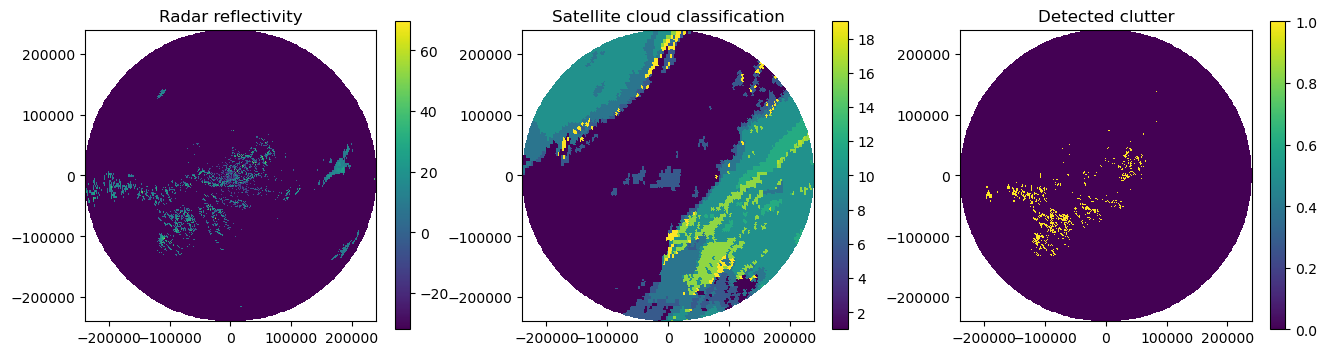

In [13]:
fig = plt.figure(figsize=(16, 8))

tilt = 0

ax = fig.add_subplot(131)
pm = vol.DBZH[tilt].wrl.vis.plot(ax=ax)
plt.colorbar(pm, shrink=0.5)
plt.title("Radar reflectivity")

ax = fig.add_subplot(132)
pm = vol.sat[tilt].wrl.vis.plot(ax=ax)
plt.colorbar(pm, shrink=0.5)
plt.title("Satellite cloud classification")

ax = fig.add_subplot(133)
pm = vol.clutter[tilt].wrl.vis.plot(ax=ax)
plt.colorbar(pm, shrink=0.5)
plt.title("Detected clutter")